<a href="https://colab.research.google.com/github/aldofranco91/Trading/blob/main/Conv_Regression_ResNet_Jaime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Feb 11 16:44:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!pip install yfinance

     |████████████████████████████████| 6.4 MB 11.1 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [5]:
import matplotlib
# importing the requests library 
import requests 
import pandas as pd
import numpy as np
import time
# Viz
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from pickle import dump, load

from IPython import display

import tensorflow as tf

from sklearn import metrics
from scipy import stats

tf.keras.utils.set_random_seed(9)
tf.test.gpu_device_name()

'/device:GPU:0'

In [6]:
pd.set_option("display.max_columns", None)

import warnings
warnings.filterwarnings('ignore')

# Get data

In [7]:
folder = '/content/drive/MyDrive/Trading/5_days_v2/'
past_t = 20
forecast_t = 5

In [8]:
import yfinance as yf
import datetime as dt

start = dt.datetime(2018,2,1)
end = dt.datetime(2022,1,31)

df = yf.download('BTC-USD', start, end).drop('Adj Close', axis=1)
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2018-02-01,10237.299805,10288.799805,8812.280273,9170.540039,9959400448
2018-02-02,9142.280273,9142.280273,7796.490234,8830.750000,12726899712
2018-02-03,8852.120117,9430.750000,8251.629883,9174.910156,7263790080
2018-02-04,9175.700195,9334.870117,8031.220215,8277.009766,7073549824
2018-02-05,8270.540039,8364.839844,6756.680176,6955.270020,9285289984
...,...,...,...,...,...
2022-01-27,36841.878906,37148.324219,35629.281250,37138.234375,25041426629
2022-01-28,37128.445312,37952.878906,36211.109375,37784.332031,22238830523
2022-01-29,37780.714844,38576.261719,37406.472656,38138.179688,17194183075


# Indicators

https://www.ig.com/es/estrategias-de-trading/los-10-mejores-indicadores-de-trading-para-inversores-190830

In [9]:
# Fear index
df_fear = pd.read_csv('/content/drive/MyDrive/Trading/fear_index.csv')
df_fear = df_fear[df_fear.date.between('2018-02-01', '2022-01-31')]
df_fear['date'] = pd.to_datetime(df_fear['date'])
df['date'] = pd.to_datetime(df.index)
df = df.join(df_fear.set_index('date'), on='date')
df = df.drop(['date'], axis=1)
df['value'] = df['value'].fillna(25) # Fill 3 consequtive days taking sorrounding values (23-26)

In [10]:
price = 'Close'

# MovingAverage
#https://towardsdatascience.com/building-a-comprehensive-set-of-technical-indicators-in-python-for-quantitative-trading-8d98751b5fb
values_ma = range(2,30,2)
for i in values_ma:
    df["maclose" + str(i)] = df[price].rolling(window=i).mean()

# ExponentialMovingWindow
values_ema = range(2,30,2)
for i in values_ema:
    df["ema" + str(i)] = df[price].ewm(span = i, adjust = False).mean()

# Wight Moving Average
# https://predictivehacks.com/?all-tips=how-to-apply-a-rolling-weighted-moving-average-in-pandas
weights = np.array([0.1, 0.2, 0.3, 0.4]) #Tienen que sumar 1 🙂
df['wma'] = df[price].rolling(4).apply(lambda x: np.sum(weights*x))

# RSI
# https://stackoverflow.com/questions/20526414/relative-strength-index-in-python-pandas
values_rsi = range(2,30,2)
close = df[price]

# Get the difference in price from previous step
delta = close.diff()

# Make the positive gains (up) and negative gains (down) Series
up, down = delta.copy(), delta.copy()
up[up < 0] = 0
down[down > 0] = 0

for i in values_rsi:
    # Calculate the EWMA
    roll_up1 = up.ewm(span=i).mean()
    roll_down1 = down.abs().ewm(span=i).mean()

    ## Calculate the RSI based on EWMA
    RS1 = roll_up1 / roll_down1
    RSI1 = 100.0 - (100.0 / (1.0 + RS1))

    # Calculate the SMA
    roll_up2 = up.rolling(i).mean()
    roll_down2 = down.abs().rolling(i).mean()

    # Calculate the RSI based on SMA
    RS2 = roll_up2 / roll_down2
    RSI2 = 100.0 - (100.0 / (1.0 + RS2))

    df["rsiewma" + str(i)] = RSI1.values
    df["rsisma" + str(i)]  = RSI2.values

# BollingerBand
values_bollinger = range(2,30,2)
for i in values_bollinger:
    df['bollingerupper' + str(i)] = df[price].rolling(window=i).mean() + (df[price].rolling(window=i).std() * 2)
    df['bollingerlower' + str(i)] = df[price].rolling(window=i).mean() - (df[price].rolling(window=i).std() * 2)

In [11]:
df = df.dropna()
df.tail(5)

,Open,High,Low,Close,Volume,value,maclose2,maclose4,maclose6,maclose8,maclose10,maclose12,maclose14,maclose16,maclose18,maclose20,maclose22,maclose24,maclose26,maclose28,ema2,ema4,ema6,ema8,ema10,ema12,ema14,ema16,ema18,ema20,ema22,ema24,ema26,ema28,wma,rsiewma2,rsisma2,rsiewma4,rsisma4,rsiewma6,rsisma6,rsiewma8,rsisma8,rsiewma10,rsisma10,rsiewma12,rsisma12,rsiewma14,rsisma14,rsiewma16,rsisma16,rsiewma18,rsisma18,rsiewma20,rsisma20,rsiewma22,rsisma22,rsiewma24,rsisma24,rsiewma26,rsisma26,rsiewma28,rsisma28,bollingerupper2,bollingerlower2,bollingerupper4,bollingerlower4,bollingerupper6,bollingerlower6,bollingerupper8,bollingerlower8,bollingerupper10,bollingerlower10,bollingerupper12,bollingerlower12,bollingerupper14,bollingerlower14,bollingerupper16,bollingerlower16,bollingerupper18,bollingerlower18,bollingerupper20,bollingerlower20,bollingerupper22,bollingerlower22,bollingerupper24,bollingerlower24,bollingerupper26,bollingerlower26,bollingerupper28,bollingerlower28
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-01-27,36841.878906,37148.324219,35629.281250,37138.234375,25041426629,20.0,36995.177734,36899.671875,36484.290365,37005.434570,38016.343750,38793.988932,39414.640346,39896.602295,40161.264106,40327.414844,40512.142223,40863.904460,41328.347806,41733.225028,37037.379432,37003.899549,37254.861371,37639.899709,38060.480683,38480.322624,38887.721390,39279.731716,39656.626900,40019.796764,40370.846062,40711.196995,41041.941079,41363.820160,36967.163672,88.297985,73.741279,60.598852,90.435293,45.956740,59.106063,39.329044,24.483816,35.917191,23.869331,33.996246,21.803489,32.868982,25.859280,32.209263,29.814816,31.844184,33.950322,31.673026,35.484824,31.633276,31.344301,31.684540,26.844454,31.800009,25.299785,31.961532,28.733783,37399.803017,36590.552452,37303.517833,36495.825917,38025.658472,34942.922257,40248.471397,33762.397744,43157.982976,32874.704524,44706.644414,32881.333450,45702.580361,33126.700331,46334.754032,33458.450557,46409.870322,33912.657890,46326.124569,34328.705119,46362.964478,34661.319968,46980.115799,34747.693120,48054.898059,34601.797554,48865.957107,34600.492949
2022-01-28,37128.445312,37952.878906,36211.109375,37784.332031,22238830523,24.0,37461.283203,37182.172852,36943.304036,36643.423828,37557.213672,38349.860026,39034.971261,39511.304199,39936.990234,40129.934375,40267.751420,40525.852702,40960.621394,41428.863839,37535.347831,37316.072542,37406.138702,37671.995780,38010.271837,38373.247148,38740.602809,39103.802342,39459.543230,39806.895361,40145.931798,40477.047797,40800.636705,41116.958910,37321.027734,98.018923,100.000000,80.489905,92.361288,62.676847,96.555508,52.409849,33.177970,46.478115,27.719120,42.808736,26.400476,40.409137,26.753990,38.781145,26.821595,37.652369,36.915482,36.862002,37.417105,36.309357,34.614930,35.928602,29.927724,35.675263,27.927296,35.518470,31.774526,38375.003271,36547.563135,38019.248314,36345.097389,37955.819005,35930.789068,38239.493610,35047.354046,41689.710650,33424.716694,43611.369062,33088.350990,44997.915346,33072.027176,45645.370890,33377.237509,46222.930187,33651.050281,46193.378676,34066.490074,46104.082916,34431.419925,46371.690700,34680.014704,47356.019874,34565.222915,48478.925181,34378.802497
2022-01-29,37780.714844,38576.261719,37406.472656,38138.179688,17194183075,24.0,37961.255859,37478.216797,37253.533203,36853.531738,37196.598828,38007.162435,38675.027065,39232.967285,39681.563802,39941.263281,40112.309482,40299.568359,40640.623798,41087.841239,37937.235735,37644.915400,37615.293270,37775.592204,38033.527810,38337.082923,38660.279726,38990.199676,39320.452331,39647.970059,39971.344658,40289.938349,40603.417667,40911.525860,37703.430469,99.162285,100.000000,86.644272,92.659430,69.832950,95.066544,58.682490,67.735259,51.795701,32.015610,47.357905,30.929744,44.358457,28.481444,42.255739,31.889182,40.743358,34.535869,39.636887,38.111872,38.819380,39.461074,38.213601,35.109074,37.766867,30.307338,37.

# Create sequences

In [12]:
#columns = ["prices", "total_volumes", "market_caps", "ema_5", "ema_10", "ema_15", "ema_30"]
columns = df.columns

df_rs = np.array(df[columns])
df_rs.shape

(1433, 91)

In [13]:
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    range = np.arange(start = 0, stop = len(sequence), step = 1) # Ojo con el step que te fundio :)
    for i in range:
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x = sequence[i:end_ix]
        seq_y = sequence[end_ix:out_end_ix][:,df.columns.get_loc(price)]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [14]:
n_steps_in = past_t
n_steps_out = forecast_t
# split into samples
X, y = split_sequence(df_rs, n_steps_in, n_steps_out)
print("Shape X --> " + str(X.shape))
print("Shape y --> " + str(y.shape))

print("Example of day -->")
pd.DataFrame(X[-1], columns=columns)

Shape X --> (1409, 20, 91)
Shape y --> (1409, 5)
Example of day -->


,Open,High,Low,Close,Volume,value,maclose2,maclose4,maclose6,maclose8,maclose10,maclose12,maclose14,maclose16,maclose18,maclose20,maclose22,maclose24,maclose26,maclose28,ema2,ema4,ema6,ema8,ema10,ema12,ema14,ema16,ema18,ema20,ema22,ema24,ema26,ema28,wma,rsiewma2,rsisma2,rsiewma4,rsisma4,rsiewma6,rsisma6,rsiewma8,rsisma8,rsiewma10,rsisma10,rsiewma12,rsisma12,rsiewma14,rsisma14,rsiewma16,rsisma16,rsiewma18,rsisma18,rsiewma20,rsisma20,rsiewma22,rsisma22,rsiewma24,rsisma24,rsiewma26,rsisma26,rsiewma28,rsisma28,bollingerupper2,bollingerlower2,bollingerupper4,bollingerlower4,bollingerupper6,bollingerlower6,bollingerupper8,bollingerlower8,bollingerupper10,bollingerlower10,bollingerupper12,bollingerlower12,bollingerupper14,bollingerlower14,bollingerupper16,bollingerlower16,bollingerupper18,bollingerlower18,bollingerupper20,bollingerlower20,bollingerupper22,bollingerlower22,bollingerupper24,bollingerlower24,bollingerupper26,bollingerlower26,bollingerupper28,bollingerlower28
0,43153.570312,43153.570312,41077.445312,41557.902344,8.419661e+10,18.0,42359.416016,43546.352539,44664.791016,45247.750488,45560.483984,46152.842773,46790.963449,47292.513916,47458.074870,47391.632031,47312.889205,47393.571289,47338.300931,47509.166713,42234.370338,43313.159453,44111.791614,44721.231367,45200.547368,45592.068592,45927.300928,46228.148145,46508.724724,46777.434120,47038.785001,47294.782348,47545.917058,47791.835270,42874.998047,0.098661,0.000000,2.562130,0.000000,6.417306,0.000000,10.170852,16.470281,13.564899,20.605138,16.547481,15.681829,19.120417,17.496373,21.316619,28.502058,23.184632,35.851738,24.776934,36.167150,26.142952,35.618682,27.325823,39.788264,28.361470,34.876327,29.278933,40.856644,44626.439026,40092.393005,47129.878070,39962.827008,49140.107454,40189.474578,49664.891143,40830.609834,49687.657777,41433.310192,50978.338353,41327.347194,52290.937490,41290.989408,53100.237568,41484.790264,52998.955404,41917.194335,52649.016104,42134.247958,52343.530115,42282.248294,52245.109044,42542.033534,52008.222590,42668.379273,52178.987795,42839.345631
1,41561.464844,42228.941406,40672.277344,41733.941406,2.806636e+10,10.0,41645.921875,42505.444336,43729.578125,44676.187500,45089.407031,45410.636393,46169.826451,46726.851562,47057.926432,47142.978320,47109.789062,47095.122070,47145.857121,47236.717913,41900.751050,42681.472234,43432.405840,44057.389154,44570.255375,44998.510564,45368.186325,45699.417940,46006.115954,46297.101481,46577.494254,46849.915073,47115.400343,47374.049487,42150.033594,20.695547,9.895025,11.028093,3.898369,11.721346,2.952014,13.983926,20.251687,16.505264,24.647139,18.914794,16.979093,21.084021,19.020314,22.982031,18.715233,24.622072,28.726814,26.035365,37.021294,27.257739,38.799803,28.323232,34.182228,29.261465,40.013095,30.096993,36.913716,41894.878705,41396.965045,44523.321968,40487.566704,47847.152092,39612.004158,49619.120451,39733.254549,49801.894167,40376.919896,49955.875072,40865.397714,51860.361750,40479.291152,52838.482199,40615.220926,53158.616034,40957.236831,52975.637818,41310.318823,52662.085695,41557.492430,52418.971230,41771.272910,52305.485204,41986.229039,52329.032466,42144.403360
2,41734.726562,42663.949219,41338.160156,41911.601562,2.129438e+10,23.0,41822.771484,42091.093750,42971.825521,43954.286133,44562.754687,44937.531901,45534.261161,46169.939453,46684.764757,46894.544531,46885.371982,46855.379395,46965.048227,46944.334542,41907.984725,42373.523966,42997.890332,43580.547467,44086.863772,44523.601487,44907.308357,45253.792484,45575.114439,45879.434822,46171.764455,46454.849992,46729.933767,46997.328940,41912.496484,51.173599,100.000000,22.372777,14.956829,18.266506,6.732109,18.474256,5.456124,19.867669,19.852715,21.568415,23.251324,23.253727,17.837799,24.802490,19.494438,26.180189,30.007471,27.390304,37.035749,28.451427,37.326284,29.386334,36.673513,30.217002,40.636632,30.962629,35.682028,42074.020887,41571.522082,43546.482473,40635.705027,46271.279843,39672.371199,48562.785462,39345.786804,49412.91077

In [15]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)
# Pred just day 5
#y = y[:,4]

test_size = 200
train_size = len(X) - test_size
X_train = X[0:train_size]
y_train = y[0:train_size]
X_test_og = X[train_size:len(X)]
y_test = y[train_size:len(X)]

scaler = MinMaxScaler(feature_range=(-1,1)) #Try this
#scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test_og.reshape(-1, X_test_og.shape[-1])).reshape(X_test_og.shape)
X_new = scaler.transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
# save the scaler
dump(scaler, open(folder + 'scaler.pkl', 'wb'))

print("Shape X_train --> " + str(X_train.shape))
print("Shape y_train --> " + str(y_train.shape))
print("Shape X_test  --> " + str(X_test.shape))
print("Shape y_test  --> " + str(y_test.shape))
print("Example of day -->")
pd.DataFrame(X_train[-1], columns=columns)

Shape X_train --> (1209, 20, 91)
Shape y_train --> (1209, 5)
Shape X_test  --> (200, 20, 91)
Shape y_test  --> (200, 5)
Example of day -->


,Open,High,Low,Close,Volume,value,maclose2,maclose4,maclose6,maclose8,maclose10,maclose12,maclose14,maclose16,maclose18,maclose20,maclose22,maclose24,maclose26,maclose28,ema2,ema4,ema6,ema8,ema10,ema12,ema14,ema16,ema18,ema20,ema22,ema24,ema26,ema28,wma,rsiewma2,rsisma2,rsiewma4,rsisma4,rsiewma6,rsisma6,rsiewma8,rsisma8,rsiewma10,rsisma10,rsiewma12,rsisma12,rsiewma14,rsisma14,rsiewma16,rsisma16,rsiewma18,rsisma18,rsiewma20,rsisma20,rsiewma22,rsisma22,rsiewma24,rsisma24,rsiewma26,rsisma26,rsiewma28,rsisma28,bollingerupper2,bollingerlower2,bollingerupper4,bollingerlower4,bollingerupper6,bollingerlower6,bollingerupper8,bollingerlower8,bollingerupper10,bollingerlower10,bollingerupper12,bollingerlower12,bollingerupper14,bollingerlower14,bollingerupper16,bollingerlower16,bollingerupper18,bollingerlower18,bollingerupper20,bollingerlower20,bollingerupper22,bollingerlower22,bollingerupper24,bollingerlower24,bollingerupper26,bollingerlower26,bollingerupper28,bollingerlower28
0,0.075012,0.053660,-0.047586,-0.056197,-0.713339,-0.600000,0.013798,0.054562,0.108835,0.155946,0.171041,0.183411,0.178530,0.172714,0.173262,0.182779,0.190402,0.191241,0.198240,0.213211,-0.005282,0.053207,0.091546,0.115740,0.132301,0.145418,0.156994,0.168440,0.180288,0.192793,0.206042,0.220024,0.234679,0.249921,0.032892,-0.986538,-0.959832,-0.943300,-0.974800,-0.851312,-0.981466,-0.753175,-0.768114,-0.669651,-0.378130,-0.599080,-0.371767,-0.537281,-0.102499,-0.489359,-0.225661,-0.453598,-0.366825,-0.428907,-0.244464,-0.410960,-0.192270,-0.398224,-0.189405,-0.389547,-0.301825,-0.384060,-0.286704,0.136861,-0.151799,0.120535,-0.047377,0.170629,0.004734,0.238376,0.021765,0.220590,0.064337,0.203042,0.090132,0.196419,0.079509,0.188285,0.083078,0.187307,0.099407,0.200503,0.109652,0.198830,0.132392,0.186160,0.141543,0.187591,0.159460,0.195189,0.186341
1,-0.058309,-0.025225,-0.128996,-0.028687,-0.677968,-0.888889,-0.039354,0.027038,0.075656,0.122777,0.160437,0.171101,0.176089,0.165268,0.164593,0.173742,0.182532,0.188071,0.189976,0.205523,-0.017309,0.026849,0.064726,0.091116,0.110148,0.125398,0.138692,0.151450,0.164281,0.177514,0.191298,0.205675,0.220620,0.236078,0.003559,-0.243896,-0.658198,-0.518711,-0.642897,-0.551327,-0.762169,-0.526201,-0.820144,-0.489102,-0.217118,-0.450105,-0.273291,-0.411069,-0.052116,-0.379865,-0.196604,-0.356998,-0.238098,-0.342717,-0.247546,-0.333048,-0.230904,-0.327025,-0.117651,-0.323880,-0.244174,-0.323019,-0.246364,-0.055454,-0.055534,0.099217,-0.080667,0.138377,-0.028255,0.211077,-0.016593,0.232361,0.027895,0.212926,0.052291,0.201352,0.068509,0.194330,0.060043,0.191224,0.076233,0.203576,0.086764,0.203015,0.110501,0.191451,0.128314,0.187794,0.141402,0.196527,0.168002
2,-0.028673,0.022218,-0.031431,0.011712,-0.750644,-0.800000,-0.005286,0.011162,0.051059,0.094036,0.141732,0.160508,0.166945,0.165628,0.160980,0.163962,0.177703,0.185135,0.187225,0.198258,0.005778,0.027486,0.057461,0.081296,0.099714,0.115009,0.128535,0.141516,0.154503,0.167819,0.181624,0.195973,0.210858,0.226234,0.001534,0.530085,1.000000,0.011192,-0.307761,-0.162149,-0.504248,-0.224426,-0.648860,-0.244790,-0.455359,-0.245845,-0.227988,-0.236245,-0.214142,-0.226964,-0.027083,-0.221217,-0.117796,-0.220916,-0.268821,-0.222458,-0.151153,-0.225589,-0.111384,-0.230037,-0.111291,-0.235559,-0.234172,-0.005972,-0.039905,0.062723,-0.073575,0.079979,-0.013685,0.151527,-0.008821,0.216252,0.007101,0.210871,0.032281,0.200450,0.050289,0.193945,0.061269,0.192311,0.067228,0.193588,0.077791,0.203443,0.099631,0.193088,0.120013,0.189161,0.133809,0.189956,0.160335
3,0.010045,0.037657,-0.010672,0.042887,-0.826461,-0.622222,0.030620,0.002474,0.044671,0.078191,0.122395,0.157897,0.161794,0.168267,0.158610,0.159983,0.172954,0.181124,0.187289,0.193337,0.034383,0.040564,0.061448,0.080860,0.097112,0.111274,0.124135,0.136653,0.149262,0.162235,0.175714,0.189748,0.204330,0.219418,0.018440,0.807465,1.000000,0.318204,-0.147825,0.087083,-0.154908,-0.021804,-0.407622,-0.075951,-0.477759,-0.101874,-0.061934,-0.111230,

# Model 

Transfer learning work-flow

https://keras.io/guides/transfer_learning/ (The typical transfer-learning workflow)

In [16]:
from tensorflow.keras import backend as K 

def euc_dist_keras(y_true, y_pred):
    return K.sqrt(K.sum(K.square(y_true - y_pred), axis=-1, keepdims=True))

def max_distance(y_true, y_pred):
    return K.max(K.abs(y_true - y_pred), axis=-1, keepdims=True)

In [17]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras import activations

Gan inspiration

https://keras.io/examples/generative/conditional_gan/

In [18]:
# Get square shape
image_shape = X_train.shape[1]

if X_train.shape[1]<X_train.shape[2]:
  image_shape = X_train.shape[2]

# Load Resnet model
base_model = tf.keras.applications.ResNet152V2(
    weights='imagenet',
    input_shape=(image_shape, image_shape, 3),
    include_top=False) 
base_model.trainable = False

# Create input as image
inputs = layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
if X_train.shape[1]<X_train.shape[2]:
  input_img = layers.Dense(image_shape, activation='tanh')(inputs)
  input_img = layers.Reshape((X_train.shape[2], X_train.shape[1]))(input_img) 
  input_img = layers.Dense(image_shape, activation='tanh')(input_img) # Create a square matrix 
  input_img = layers.Reshape((image_shape, image_shape, 1))(input_img) # Reshape into an image with 1 channels
  input_img = layers.Dense(3, activation='tanh', name='image_inp')(input_img) # Learn 3 channels
else:
  input_img = layers.Dense(image_shape, activation='tanh')(inputs) # Create a square matrix 
  input_img = layers.Reshape((image_shape, image_shape, 1))(input_img) # Reshape into an image with 1 channels
  input_img = layers.Dense(3, activation='tanh', name='image_inp')(input_img) # Learn 3 channels
# With tahn all outputs are between -1 and 1 (ResNet needs that)

# Create Model
x = base_model(input_img, training=False)
x = layers.GlobalAveragePooling2D()(x)
#x = layers.Dropout(0.2)(x) 

# Output layer
predictions = layers.Dense(y_train.shape[1])(x) #Relu for getting positive values
model = tf.keras.Model(inputs, predictions)

model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics='mae')
model.summary()

234561536/234545216 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20, 91)]          0         
                                                                 
 dense (Dense)               (None, 20, 91)            8372      
                                                                 
 reshape (Reshape)           (None, 91, 20)            0         
                                                                 
 dense_1 (Dense)             (None, 91, 91)            1911      
                                                                 
 reshape_1 (Reshape)         (None, 91, 91, 1)         0         
                                                                 
 image_inp (Dense)           (None, 91, 91, 3)         6         
                                                            

In [19]:
#tf.keras.utils.plot_model(model, to_file="model.png")

In [20]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='loss', patience=7, verbose=1, mode='auto')
learning_rate_reduction = ReduceLROnPlateau(monitor='loss', patience=5, verbose=1, factor=0.5, min_lr=5e-5)

Batch sizes

{1, 2, 4, 8, 16} - slow 

{ [32, 64],[ 128, 256] }- Good starters

[32, 64] - CPU

[128, 256] - GPU for more boost

In [21]:
history = model.fit(X_train, y_train, epochs = 700, batch_size = 128, 
                    callbacks=[learning_rate_reduction, early_stopping],
                    validation_data= (X_test, y_test))

Epoch 1/700
10/10 [==============================] - 24s 647ms/step - loss: 414316736.0000 - mae: 14356.7002 - val_loss: 2446599680.0000 - val_mae: 48700.4258 - lr: 0.0100
Epoch 2/700
10/10 [==============================] - 3s 290ms/step - loss: 406752832.0000 - mae: 14062.5225 - val_loss: 2409564160.0000 - val_mae: 48322.2461 - lr: 0.0100
Epoch 3/700
10/10 [==============================] - 3s 290ms/step - loss: 392159680.0000 - mae: 13492.1904 - val_loss: 2351449344.0000 - val_mae: 47723.2344 - lr: 0.0100
Epoch 4/700
10/10 [==============================] - 3s 289ms/step - loss: 372404544.0000 - mae: 12709.6006 - val_loss: 2285145344.0000 - val_mae: 47023.5352 - lr: 0.0100
Epoch 5/700
10/10 [==============================] - 3s 307ms/step - loss: 351254464.0000 - mae: 11808.3408 - val_loss: 2190219776.0000 - val_mae: 46013.3906 - lr: 0.0100
Epoch 6/700
10/10 [==============================] - 3s 305ms/step - loss: 327721856.0000 - mae: 10777.7051 - val_loss: 2096330240.0000 - val_ma

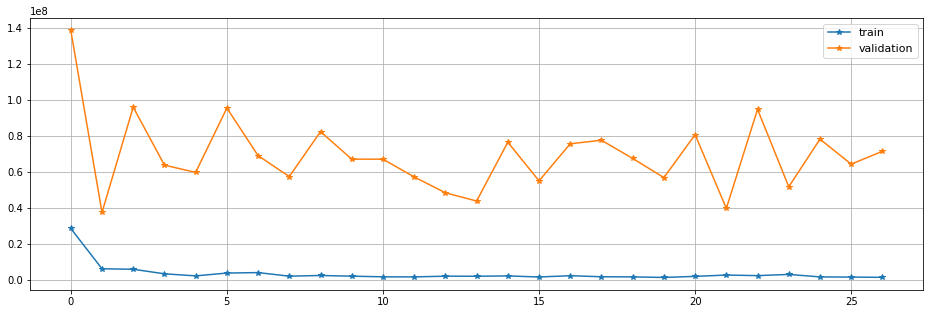

In [27]:
plt.figure(figsize=(16,5))
plt.plot(history.history['loss'], label='train', marker='*')
plt.plot(history.history['val_loss'], label='validation', marker='*')
plt.grid()
plt.legend(fontsize=11)

## Fine-tuning

In [28]:
model_path = folder + 'modelo_best.h5'
checkpoint = ModelCheckpoint(model_path, monitor="val_loss",
                             save_freq = 'epoch', save_best_only=True, mode='min') 
learning_rate_reduction = ReduceLROnPlateau(monitor='loss', patience=5, verbose=1, factor=0.5, min_lr=1.25e-6)

In [24]:
# Unfreeze the base model
base_model.trainable = True

# Very low learning rate 
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), metrics='mae') 

history = model.fit(X_train, y_train, epochs = 50, batch_size = 16,
                    validation_data= (X_test, y_test),
                    callbacks=[early_stopping, checkpoint])

Epoch 1/50
76/76 [==============================] - 40s 342ms/step - loss: 28714746.0000 - mae: 3193.7324 - val_loss: 138664368.0000 - val_mae: 10600.7578
Epoch 2/50
76/76 [==============================] - 14s 186ms/step - loss: 6352540.5000 - mae: 1568.5261 - val_loss: 37627252.0000 - val_mae: 4952.0972
Epoch 3/50
76/76 [==============================] - 9s 119ms/step - loss: 6075330.5000 - mae: 1449.6625 - val_loss: 96032160.0000 - val_mae: 8365.0664
Epoch 4/50
76/76 [==============================] - 9s 125ms/step - loss: 3559671.0000 - mae: 1150.0635 - val_loss: 63871628.0000 - val_mae: 6557.0068
Epoch 5/50
76/76 [==============================] - 9s 114ms/step - loss: 2404951.2500 - mae: 922.8182 - val_loss: 59808380.0000 - val_mae: 6323.3149
Epoch 6/50
76/76 [==============================] - 9s 115ms/step - loss: 3970043.2500 - mae: 1132.0342 - val_loss: 95565888.0000 - val_mae: 8111.6177
Epoch 7/50
76/76 [==============================] - 9s 114ms/step - loss: 4230245.0000 - m

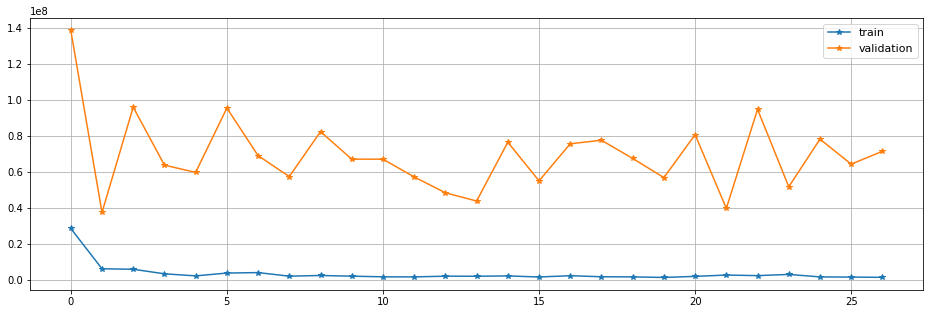

In [25]:
plt.figure(figsize=(16,5))
plt.plot(history.history['loss'], label='train', marker='*')
plt.plot(history.history['val_loss'], label='validation', marker='*')
plt.grid()
plt.legend(fontsize=11)

In [26]:
best_model = tf.keras.models.load_model(model_path)
best_model.evaluate(X_test, y_test)

7/7 [==============================] - 3s 48ms/step - loss: 37627204.0000 - mae: 4952.0933


[37627204.0, 4952.09326171875]

# Images created 

In [29]:
sub_model = tf.keras.Model(inputs=best_model.input, outputs=best_model.get_layer('image_inp').output)
sub_model.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics='mae')
layer_output = sub_model.predict(X_new, verbose=1)

45/45 [==============================] - 0s 2ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 0.98, 'Image Input 1000')

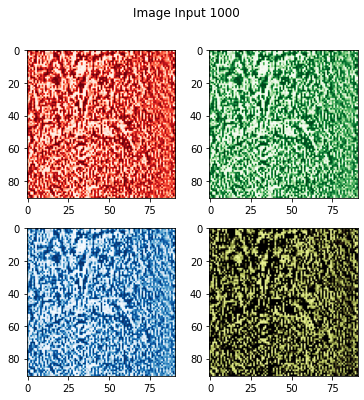

In [30]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6))
axs[0,0].imshow(layer_output[1000][:,:,0], cmap='Reds')
axs[0,1].imshow(layer_output[1000][:,:,1], cmap='Greens')
axs[1,0].imshow(layer_output[1000][:,:,1], cmap='Blues')
axs[1,1].imshow(layer_output[1000])
fig.suptitle('Image Input 1000', fontsize=12)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


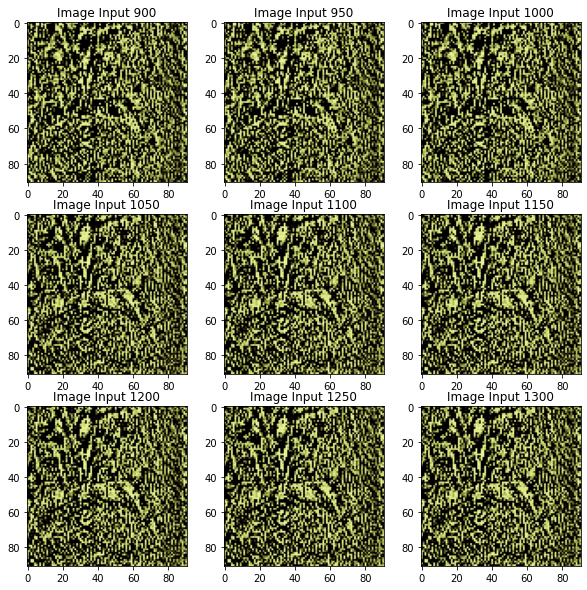

In [32]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

for idx,i in enumerate(range(900,1350,50)):
  axs.flat[idx].imshow(layer_output[i])
  axs.flat[idx].set_title('Image Input ' + str(i))

# Results

Dummy regressor

In [42]:
from sklearn.metrics import mean_absolute_error
day_pred = 4

y_dummy = X_test_og[:,-1, 3] #The price in 5 days is the same as today
print(mean_absolute_error(y_test[:,day_pred], y_dummy))

2895.221142578125


In [34]:
y_pred_test = best_model.predict(X_test, verbose=1)
y_pred_redes = best_model.predict(X_new, verbose=1)

45/45 [==============================] - 2s 52ms/step


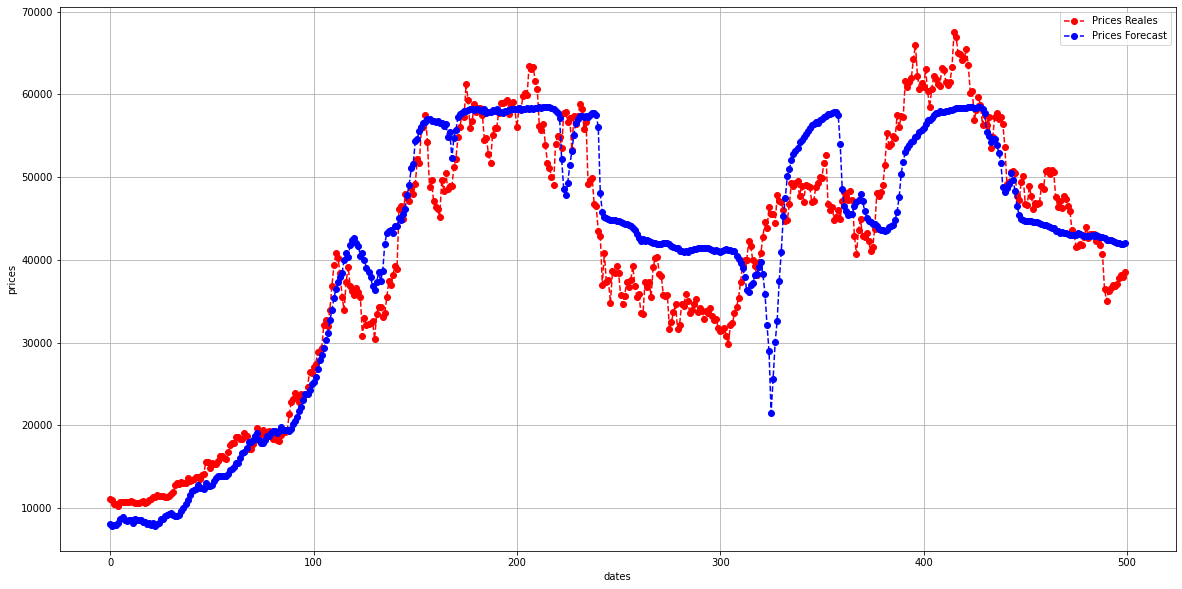

In [43]:
last_steps = 500
fig=plt.figure(figsize=(20, 10))
plt.plot(y[-last_steps:, day_pred], '--bo', label = 'Prices Reales', color = "r")
plt.plot(y_pred_redes[-last_steps:, day_pred], '--bo', label = 'Prices Forecast', color = "b")
plt.xlabel('dates')
plt.ylabel('prices')
plt.legend()
plt.grid(True)
plt.savefig('imagen.png', dpi = 200)
plt.show()

In [44]:
y_test_original = y_test
y_pred_test = y_pred_test

y_original = y
y_pred_full = y_pred_redes

In [45]:
for i in range(0,len(y_test[0])):
  print('Errors day ' + str(i) + ': ' + str(mean_absolute_error(y_test[:,i], y_pred_test[:,i])))

Errors day 0: 4796.59923828125
Errors day 1: 4876.80330078125
Errors day 2: 4981.858505859375
Errors day 3: 5045.234267578125
Errors day 4: 5059.969326171875


In [47]:
errores_test = np.empty([len(y_test)])
for i in range(0,len(y_test)):
    errores_test[i] = np.linalg.norm(y_test_original[i] - y_pred_test[i], np.inf)

errores_full = np.empty([len(y)])
for i in range(0,len(y)):
    errores_full[i] = np.linalg.norm(y_original[i] - y_pred_full[i], np.inf)

In [48]:
print("Errores Test")
print(pd.DataFrame(errores_test).describe().transpose().round(2))
print("Errores Full")
print(pd.DataFrame(errores_full).describe().transpose().round(2))

Errores Test
   count     mean      std     min      25%      50%     75%       max
0  200.0  6615.87  3601.24  681.61  4277.85  6202.82  8763.4  24826.32
Errores Full
    count    mean      std    min      25%      50%      75%       max
0  1409.0  3424.0  2760.05  56.38  1938.35  2609.48  3649.05  24826.32


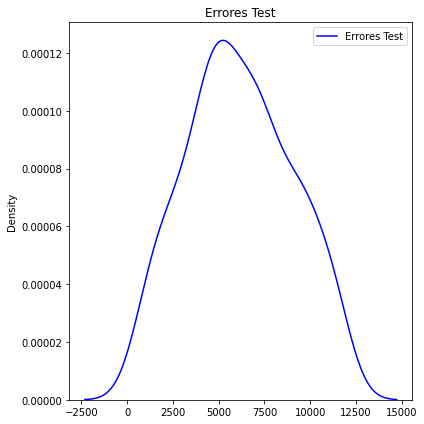

In [49]:
plt.figure(figsize=(6,6))
sns.kdeplot(errores_test[errores_test < np.percentile(errores_test, 95)], color = "blue", label = 'Errores Test')
plt.title('Errores Test')
plt.tight_layout()
plt.legend()
plt.show()

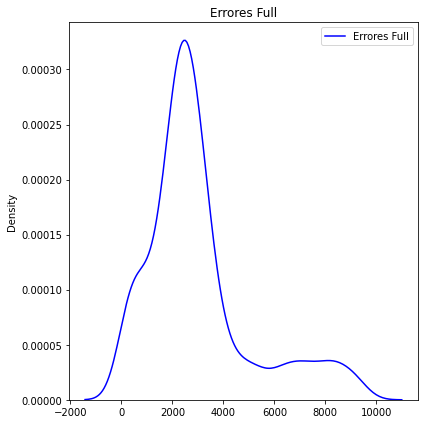

In [50]:
plt.figure(figsize=(6,6))
sns.kdeplot(errores_full[errores_full < np.percentile(errores_full, 95)], color = "blue", label = 'Errores Full')
plt.title('Errores Full')
plt.tight_layout()
plt.legend()
plt.show()

In [51]:
best_redes_test = np.argmin(errores_test)
worse_redes_test = np.argmax(errores_test)

best_redes_full = np.argmin(errores_full)
worse_redes_full = np.argmax(errores_full)

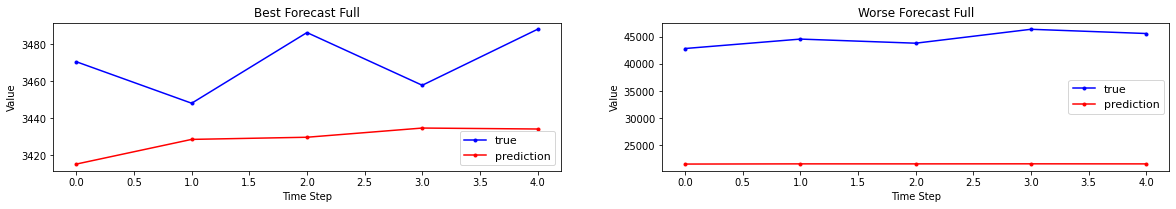

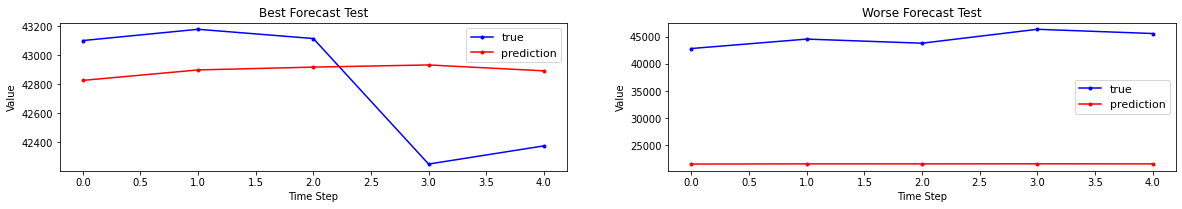

In [52]:
plt.figure(figsize=(20, 6))
plt.subplot(221)
plt.title("Best Forecast Full")
plt.plot(y_original[best_redes_full], color = "blue", marker='.', label="true")
plt.plot(y_pred_full[best_redes_full], color = 'red', marker = ".", label="prediction")
plt.ylabel('Value'); plt.xlabel('Time Step'); plt.legend(fontsize=11)

plt.subplot(222)
plt.title("Worse Forecast Full")
plt.plot(y_original[worse_redes_full], color = "blue", marker='.', label="true")
plt.plot(y_pred_full[worse_redes_full], color = 'red', marker = ".", label="prediction")
plt.ylabel('Value'); plt.xlabel('Time Step'); plt.legend(fontsize=11)

plt.figure(figsize=(20, 6))
plt.subplot(223)
plt.title("Best Forecast Test")
plt.plot(y_test_original[best_redes_test],  color = "blue", marker='.', label="true")
plt.plot(y_pred_test[best_redes_test], color = 'red', marker = ".", label="prediction")
plt.ylabel('Value'); plt.xlabel('Time Step'); plt.legend(fontsize=11)

plt.subplot(224)
plt.title("Worse Forecast Test")
plt.plot(y_test_original[worse_redes_test], color = "blue", marker='.', label="true")
plt.plot(y_pred_test[worse_redes_test], color = 'red', marker = ".", label="prediction")
plt.ylabel('Value'); plt.xlabel('Time Step'); plt.legend(fontsize=11) 
plt.show();